# Unsupervised State-Space Modelling Using Reproducing Kernels
### by Angelo Falchetti

The following is a demonstration of **pykssm**, a simple library for unsupervised kernel state-space modelling (KSSM), which allows the user to estimate the transition function of a nonlinear state-space model without supervision, i.e. only by looking at the output observations of the system, with no access to the internal state.

The system is assumed to be of the form
$$
\begin{aligned}
x_t &= f(x_{t-1}) + \eta \\
y_t &= h(x_t) + \mu,
\end{aligned}
$$
where $\eta$ and $\mu$ are random variables (usually gaussian).

Then, $f(x)$ is estimated in a Reproducing Kernel Hilbert Space defined by the user, i.e. as the parametric $\hat f(x) = \sum_{i=1}^N a_i K(x, s^i), \; a_i \in \mathbb{R}$.

Three systems are explored: static offline estimation, where there exists a fixed transition function $f$; time-varying online estimation, where the transition function $f_t$ changes with time; and frequency estimation, which uses real data and is estimated using more than one time step (nonlinear autoregressive model).

Based on the work of Felipe A. Tobar, Petar M. Djurić and Danilo P. Mandic, ["Unsupervised State-Space Modeling Using Reproducing Kernels." IEEE Transactions on Signal Processing 63.19 (2015): 5210-5221.](http://ieeexplore.ieee.org/document/7130658/). If you've found the code useful for your own work, please cite the paper.

In [1]:
# Headers
import sys
sys.path.append("..")

import numpy as np
import pykssm
from matplotlib import rcParams
import matplotlib.pyplot as mtp
from mpl_toolkits.mplot3d import Axes3D

rcParams['axes.labelsize']   = 18
rcParams['xtick.labelsize']  = 18
rcParams['ytick.labelsize']  = 18
rcParams['legend.fontsize']  = 18
rcParams['axes.titlesize']   = 18
rcParams['axes.labelsize']   = 18
rcParams['font.family']      = 'sans-serif'
rcParams['font.serif']       = ['Computer Modern Roman']
rcParams['font.sans-serif']  = ['Helvetica']
rcParams['mathtext.fontset'] = 'stix'
rcParams['text.usetex']      = True

rcParams['lines.markeredgewidth'] = 1.5
rcParams['lines.linewidth']       = 1.5

%load_ext autoreload
%autoreload 2
#%matplotlib notebook

# Offline Modelling

In the first scenario, a fixed transition function $f(x) = 10 \,\text{sinc}(\frac{x}{7})$ is used, as well as the trivial identity sensor model $h(x) = x$. The system is run for 40 iterations.

The model can be written as
$$
\begin{aligned}
x_t &= f(x_{t-1}) + \eta &&= 10 \,\text{sinc}(\frac{x_{t-1}}{7}) + \mathcal{N}(0, 2^2) \\
y_t &= h(x_t) + \mu &&= x_t + \mathcal{N}(0, 2^2).
\end{aligned}
$$

The first state is drawn from $\mathcal{N}(0, 10)$.

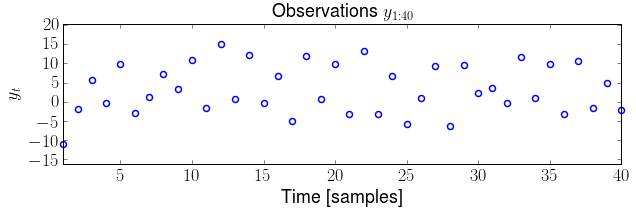

In [2]:
# Simple model
f  = lambda x: 10 * np.sinc(x / 7)
h  = lambda x: x

sigmax0 = np.sqrt(10)
sigmax  = 2
sigmay  = 2
size    = 40

x0 = 0 + np.random.randn() * sigmax0

(x, y) = pykssm.filter(f, h, sigmax, sigmay, x0, size)

# Let's see the data we'll be working with,
# the output of the filter
mtp.figure(figsize=(10, 2.5))
mtp.plot(list(range(1, size + 1)), y, "o", markerfacecolor="none", markeredgecolor="b", clip_on=False)
mtp.title("Observations $y_{1:" + str(size) + "}$")
mtp.xlabel("Time [samples]")
mtp.ylabel("$y_t$")

yrange = np.max(y) - np.min(y)
mtp.axis([1, size, np.min(y) - 0.2 * yrange, np.max(y) + 0.2 * yrange])

mtp.show()

In [3]:
%%time
# KSSM, the core of this notebook
(samples, like, svectors, kernel) = (
    pykssm.offline(observations = y[np.newaxis].T,
                   hsensor      = lambda x: x,
                   invhsensor   = lambda y: y,
                   kernel       = pykssm.GaussianKernel(np.sqrt(10)),
                   nsamples     = 1200,
                   sigmax       = sigmax,
                   sigmay       = sigmay,
                   smcprior     = lambda: np.array([0 + np.random.randn() * sigmax0]),
                   verbose      = True))

# kernel (output) describes the used kernel reproducing hilbert space, with all parameters set (in this case sigma is
# set to sqrt(10) but if the argument is ommited from the input kernel argument, it would be deduced from the data);
# 
# svectors are the support vectors for the representation of the transition function, i.e. the components
# that will be mixed together to form a function;
# 
# samples is a list of samples from the distribution p(f_t | y_{1:T}), where f_t is represented by a list {a_i}
# of mixing parameters that weight each support vector.
# So, each sampled transition function can be calculated using the expression
# f(x) = sum(a_i * kernel(svectors[i], x)).
# 
# like are the likelihoods of each sample.
# 
# For this example, a gaussian kernel has been used (usually good for its universality properties),
# but it may be replaced with any other (and it's very simple to create new kernels).

# Supervised alternative (Kernel regression)
supervisedf = pykssm.kls(x[:-1][np.newaxis].T, x[1:][np.newaxis].T, svectors, kernel, 1.0)

sample 1 | ratio: 1.0
sample 2 | ratio: 0.5
sample 3 | ratio: 0.3333333333333333
sample 4 | ratio: 0.5
sample 5 | ratio: 0.4
sample 6 | ratio: 0.5
sample 7 | ratio: 0.5714285714285714
sample 8 | ratio: 0.625
sample 9 | ratio: 0.6666666666666666
sample 10 | ratio: 0.7
sample 11 | ratio: 0.7272727272727273
sample 12 | ratio: 0.75
sample 13 | ratio: 0.6923076923076923
sample 14 | ratio: 0.6428571428571429
sample 15 | ratio: 0.6
sample 16 | ratio: 0.5625
sample 17 | ratio: 0.5294117647058824
sample 18 | ratio: 0.5
sample 19 | ratio: 0.47368421052631576
sample 20 | ratio: 0.45
sample 21 | ratio: 0.42857142857142855
sample 22 | ratio: 0.45454545454545453
sample 23 | ratio: 0.4782608695652174
sample 24 | ratio: 0.5
sample 25 | ratio: 0.52
sample 26 | ratio: 0.5384615384615384
sample 27 | ratio: 0.5555555555555556
sample 28 | ratio: 0.5714285714285714
sample 29 | ratio: 0.5862068965517241
sample 30 | ratio: 0.6
sample 31 | ratio: 0.5806451612903226
sample 32 | ratio: 0.5625
sample 33 | ratio: 

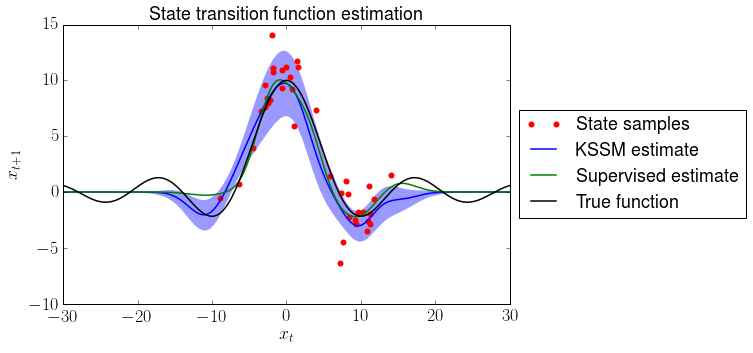

In [4]:
# State transition function estimation
limit = 5.0 * np.ceil(1/5.0 * 2.0 * max(abs(min(x)), abs(max(x))))
grid  = np.arange(-limit, limit, 0.025)

# Discard the first 200 samples as the MCMC converges to the desired distribution
smean = np.mean(np.array(samples[200:]), 0)
svar  = np.var (np.array(samples[200:]), 0)

# Real transition function
real  = [f(i) for i in grid]

# Mean estimate and its marginal deviation (note that
# since support vectors are constants and the mixture
# is a linear combination, the variance just requires
# evaluating the mixture with the weight variances)
estmean = np.array([kernel.mixture_eval(smean, svectors, [i])[0] for i in grid])
estvar  = np.array([kernel.mixture_eval(svar,  svectors, [i])[0] for i in grid])
eststd  = np.sqrt(estvar)

estsupervised = np.array([kernel.mixture_eval(supervisedf, svectors, [i])[0] for i in grid])

mtp.figure(figsize = (8, 5))

# Observed transitions
mtp.plot(x[:-1], x[1:], "or", clip_on=False, label="State samples", markeredgewidth=0.0)
#mtp.plot(np.array(svectors).T[0], np.zeros(len(svectors)),
#         "ob", clip_on=False, label="Support vector centers", markeredgewidth=0.0)

mtp.fill_between(grid, estmean - eststd, estmean + eststd, color="b", alpha=0.4, linewidth=0.0)
mtp.plot(grid, estmean, "-b", label = "KSSM estimate")
mtp.plot(grid, estsupervised, "-g", label = "Supervised estimate")
mtp.plot(grid, real, "-k", label = "True function")

mtp.legend(loc='center left', bbox_to_anchor=(1, 0.5))
mtp.title("State transition function estimation")
mtp.xlabel("$x_t$")
mtp.ylabel("$x_{t+1}$")
mtp.xlim(np.min(grid), np.max(grid))

mtp.show()

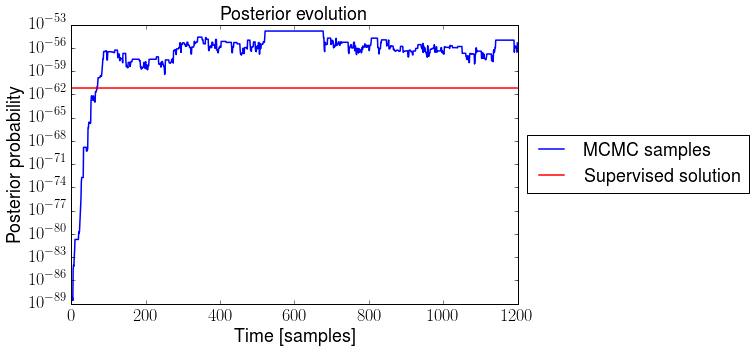

In [5]:
# Posterior evolution

# Supervised alternative
sfilter = pykssm.SMC(observations = y[np.newaxis].T,
                     prior        = lambda: 0.1,# + np.random.randn() * 10,
                     ftransition  = lambda x: kernel.mixture_eval(supervisedf, svectors, x) + np.random.randn() * sigmax,
                     hsensor      = lambda x, y: 0.5/sigmay * np.exp(-0.5 * np.dot(x - y, x - y) / sigmay**2),
                     nsamples     = 200)
supervisedlike = sfilter.get_likelihood() * np.ones(len(samples))

mtp.figure(figsize = (8, 5))

mtp.semilogy(like,           "-b", label="MCMC samples")
mtp.semilogy(supervisedlike, "-r", label="Supervised solution")

mtp.legend(loc='center left', bbox_to_anchor=(1, 0.5))
mtp.title("Posterior evolution")
mtp.xlabel("Time [samples]")
mtp.ylabel("Posterior probability")

mtp.show()

# Online Modelling

In the second scenario, the transition function varies in time, following the equation
$$
f(x) = \left\{
	\begin{array}{ll}
		\frac{x}{2} + 25 \frac{x}{1 + x^2} & \mbox{if } x < 30 \\
		\frac{60 - t}{30} \cdot (\frac{x}{2} + 25 \frac{x}{1 + x^2}) + \frac{t - 30}{30} \cdot 10 \, \text{sinc}(\frac{x}{7}) & \mbox{if } 30 \leq x \leq 60 \\
		10 \, \text{sinc}(\frac{x}{7}) & \mbox{if } x > 60.
	\end{array}
\right.
$$

The sensor model is a linear function of the state, $h(x) = \frac{x}{2} + 5$. The system is run for 90 iterations.

The model can be written as
$$
\begin{aligned}
x_t &= f_t(x_{t-1}) + \eta &&= f_t(x_{t-1}) + \mathcal{N}(0, 2^2) \\
y_t &= h(x_t) + \mu &&= \frac{x}{2} + 5 + \mathcal{N}(0, 2^2).
\end{aligned}
$$

The first state is drawn from $\mathcal{N}(0, 1^2)$.

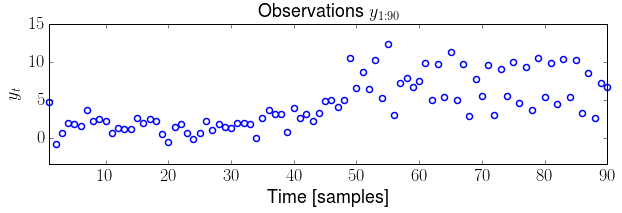

In [6]:
# Time-varying model
def ft(t, x):
    # time-invariant stable 
    def flow(x):
        return x / 2 + 25 * x / (1 + x * x)
    
    # time-invariant unstable (two accumulation points)
    def fhigh(x):
        return 10 * np.sinc(x / 7)
    
    # linear interpolation between the previous two
    def fmid(t, x):
        return (60 - t) / 30 * flow(x) + (t - 30) / 30 * fhigh(x)
    
    if t < 30:
        return flow(x)
    elif t > 60:
        return fhigh(x)
    else:
        return fmid(t, x)

ht = lambda x: x / 2 + 5

sigmaxt0 = 1
sigmaxt  = 1
sigmayt  = np.sqrt(0.5)
sizet    = 90

xt0 = 0 + np.random.randn() * sigmaxt0

(xt, yt) = pykssm.filter_t(ft, ht, sigmaxt, sigmayt, xt0, sizet)

# Output of the filter
mtp.figure(figsize=(10, 2.5))
mtp.plot(list(range(1, sizet + 1)), yt, "o", markerfacecolor="none", markeredgecolor="b", clip_on=False)
mtp.title("Observations $y_{1:" + str(sizet) + "}$")
mtp.xlabel("Time [samples]")
mtp.ylabel("$y_t$")

yrange = np.max(yt) - np.min(yt)
mtp.axis([1, sizet, np.min(yt) - 0.2 * yrange, np.max(yt) + 0.2 * yrange])

mtp.show()

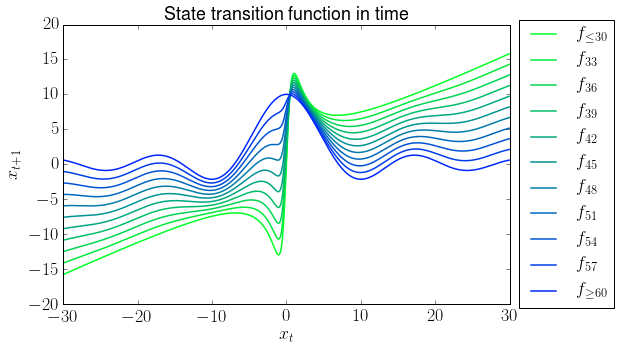

In [7]:
# Filter state transition function in time
limit = 10.0 * np.ceil(1/10.0 *2.0 * max(abs(min(xt)), abs(max(xt))))
grid  = np.arange(-limit, limit, 0.025)

mtp.figure(figsize=(8, 5))
for t in range(30, 61, 3):
    labelindex = str(t)
    
    if t == 30:
        labelindex = "\le 30"
    elif t == 60:
        labelindex = "\ge 60"
    
    mtp.plot(grid, [ft(t, i) for i in grid], "-",
             color=(0, 0.15 + 0.85 * (1 - (t - 30) / 30), 0.15 + 0.85 * (t - 30) / 30),
             label="$f_{" + labelindex + "}$")

mtp.legend(loc='center left', bbox_to_anchor=(1, 0.5))
mtp.title("State transition function in time")
mtp.xlabel("$x_t$")
mtp.ylabel("$x_{t+1}$")

mtp.show()

In [8]:
%%time
#%%prun -D profile.prof -q
# Time-varying KSSM, the core of this notebook

# (state transition function) transition standard deviation
sigmaf = 0.2

estimate = pykssm.online(observations = yt[np.newaxis].T,
                         hsensor      = lambda x: (x / 2 + 5),
                         invhsensor   = lambda y: 2 * (y - 5),
                         theta        = lambda f1, f2: 1.0 / ((2 * np.pi)**len(f1) * sigmaf) *
                                                       np.exp(-0.5 * np.sum((f1 - f2) * (f1 - f2)) / sigmaf**2),
                         kernel       = pykssm.GaussianKernel(),
                         nsamples     = 400,
                         sigmax       = sigmaxt,
                         sigmay       = sigmayt,
                         smcprior     = lambda: np.array([0 + np.random.randn() * sigmaxt0]),
                         verbose      = True)

# estimate is an array of tuples of the form (samples, likelihoods, svectors, kernel), each one corresponding
# to a time step and similar to the offline case.

time 1
time 2
time 3
time 4
time 5
time 6
time 7
time 8
time 9
time 10
time 11
time 12
time 13
time 14
time 15
time 16
time 17
time 18
time 19
time 20
time 21
time 22
time 23
time 24
time 25
time 26
time 27
time 28
time 29
time 30
time 31
time 32
time 33
time 34
time 35
time 36
time 37
time 38
time 39
time 40
time 41
time 42
time 43
time 44
time 45
time 46
time 47
time 48
time 49
time 50
time 51
time 52
time 53
time 54
time 55
time 56
time 57
time 58
time 59
time 60
time 61
time 62
time 63
time 64
time 65
time 66
time 67
time 68
time 69
time 70
time 71
time 72
time 73
time 74
time 75
time 76
time 77
time 78
time 79
time 80
time 81
time 82
time 83
time 84
time 85
time 86
time 87
time 88
time 89
CPU times: user 13min 1s, sys: 1.31 s, total: 13min 3s
Wall time: 13min 3s


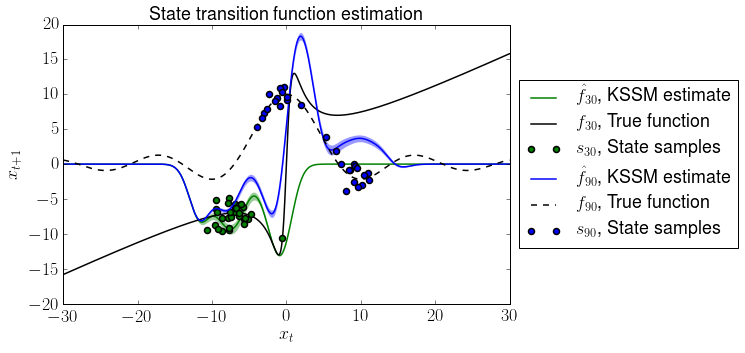

In [9]:
# Time-varying state transition function estimation
limit = 10.0 * np.ceil(1/10.0 * 2.0 * max(abs(min(xt)), abs(max(xt))))
grid  = np.arange(-limit, limit, 0.025)

# We'll observe the estimate at two moments: 30 and 90 seconds,
# which are the end points for both time-invariant zones.
# The estimates' first index correspond to the samples, of which
# the first 200 are discarded while the MCMC converges to the desired distribution
smean30 = np.mean(np.array(estimate[30 - 1][0][200:]), 0)
svar30  = np.var (np.array(estimate[30 - 1][0][200:]), 0)

smean90 = np.mean(np.array(estimate[89 - 1][0][200:]), 0)
svar90  = np.var (np.array(estimate[89 - 1][0][200:]), 0)

# The estimates' second index corresponds to the support vectors at that time
svectors30 = estimate[30 - 1][2]
svectors90 = estimate[89 - 1][2]

# The estimates' third index corresponds to the kernel descriptor
kernel30 = estimate[30 - 1][3]
kernel90 = estimate[89 - 1][3]

# Real transition functions
real30  = [ft(30, i) for i in grid]
real90  = [ft(89, i) for i in grid]

# Mean estimate and its marginal deviation
estmean30 = np.array([kernel30.mixture_eval(smean30, svectors30, [i])[0] for i in grid])
estvar30  = np.array([kernel30.mixture_eval(svar30,  svectors30, [i])[0] for i in grid])
eststd30  = np.sqrt(estvar30)

estmean90 = np.array([kernel90.mixture_eval(smean90, svectors90, [i])[0] for i in grid])
estvar90  = np.array([kernel90.mixture_eval(svar90,  svectors90, [i])[0] for i in grid])
eststd90  = np.sqrt(estvar90)

mtp.figure(figsize = (8, 5))

# First time-invariant zone estimate
mtp.fill_between(grid, estmean30 - eststd30, estmean30 + eststd30, color="g", alpha=0.4, linewidth=0.0)
mtp.plot(grid, estmean30, "-g", label = "$\hat f_{30}$, KSSM estimate")
mtp.plot(grid, real30, "-k", label = "$f_{30}$, True function")
#mtp.plot(2 * (yt[0:30] - 5), 2 * (yt[1:31] - 5), "og", clip_on=False, label="$s_{30}$, State samples")
mtp.plot(xt[0:30], xt[1:31], "og", clip_on=False, label="$s_{30}$, State samples")

#mtp.plot(np.array(svectors90).T[0], np.zeros(len(svectors90)),
#         "ob", clip_on=False, label="Support vector centers", markeredgewidth=0.0)

# Second time-invariant zone estimate
mtp.fill_between(grid, estmean90 - eststd90, estmean90 + eststd90, color="b", alpha=0.4, linewidth=0.0)
mtp.plot(grid, estmean90, "-b", label = "$\hat f_{90}$, KSSM estimate")
mtp.plot(grid, real90, "--k", label = "$f_{90}$, True function")
#mtp.plot(2 * (yt[60:89] - 5), 2 * (yt[61:90] - 5), "ob", clip_on=False, label="$s_{90}$, State samples")
mtp.plot(xt[60:89], xt[61:90], "ob", clip_on=False, label="$s_{90}$, State samples")

mtp.legend(loc='center left', bbox_to_anchor=(1, 0.5))
mtp.title("State transition function estimation")
mtp.xlabel("$x_t$")
mtp.ylabel("$x_{t+1}$")

mtp.show()

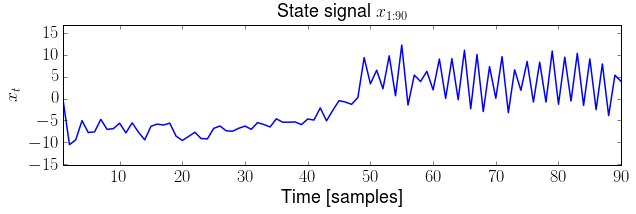

In [10]:
# Internal state of the filter
mtp.figure(figsize=(10, 2.5))
mtp.plot(list(range(1, sizet + 1)), xt, "-b")
mtp.title("State signal $x_{1:" + str(sizet) + "}$")
mtp.xlabel("Time [samples]")
mtp.ylabel("$x_t$")

xrange = np.max(xt) - np.min(xt)
mtp.axis([1, sizet, np.min(xt) - 0.2 * xrange, np.max(xt) + 0.2 * xrange])

mtp.show()

# Frequency Analysis

In the third scenario, 200 data points are extracted from a real stream of frequency measurements of the [UK national grid for the day 17 July 2014](http://www.gridwatch.templar.co.uk/), which has been normalized into the $[-8, 8]$ region.

To be able to measure the performance of the algorithm, these measurements have been used as groundtruth state, and measurements have been synthesized on top of them by adding additive gaussian noise from $\mathcal{N}(0, 0.25^2)$.

The state transition noise has been assumed normal from $\mathcal{N}(0, 0.25^2)$.

To estimate and predict the frequency just using the previous time step doesn't have much power, so this experiment will use two time steps to predict. This way there's both information about the frequency and its derivative (albeit noisy). This means that the transition function becomes multivariate, of the form
$$
F_t(X_t) =
\begin{pmatrix}f_t(x_t, x_{t-1}) \\
x_t \end{pmatrix}.
$$

The sensor model is the identity function (for the first state coordinate) with the additional noise indicated above.

The full model can be written as
$$
\begin{aligned}
\begin{pmatrix}x_t\\
x_{t-1} \end{pmatrix} &= F_t\begin{pmatrix}x_{t-1}\\
x_{t-2}\end{pmatrix} + \eta &&= \begin{pmatrix}f_t(x_t, x_{t-1}) \\
x_t \end{pmatrix} + \mathcal{N}(0, 
\begin{pmatrix}0.25^2 & 0 \\
0 & 0 \end{pmatrix}) \\
y_t &= h(x_t) + \mu &&= \begin{pmatrix}1 & 0\end{pmatrix} \begin{pmatrix}x_t \\ x_{t-1}\end{pmatrix} + \mathcal{N}(0, 0.25^2),
\end{aligned}
$$

where $f_t(\cdot)$ is estimated using kernels, just like the previous experiments.

The first state is drawn from $\mathcal{N}(0, 0.25^2)$.

Note that the details of the nonlinear autoregressive model are not explicitly coded (including heuristics on the undetermined sensor function inverse). Instead the library automatically expands everything as necessary; the only required input is the number of delays to consider.

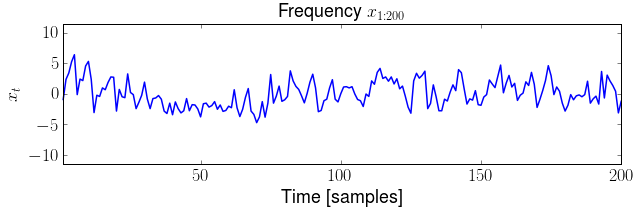

In [11]:
# UK national grid frequency data
frequency = np.load("frequency.npy")
frequency = 50 * (frequency - 50)
delays    = 1

sigmaxf0 = 0.25
sigmaxf  = 0.25
sigmayf  = 0.25

xf = frequency[:200]
yf = np.array([x + sigmayf * np.random.randn() for x in xf])

sizefq = len(xf)

# Plot of the input data
mtp.figure(figsize=(10, 2.5))
mtp.plot(list(range(1, sizefq + 1)), xf, "-", markerfacecolor="none", markeredgecolor="b", clip_on=False)
mtp.title("Frequency $x_{1:" + str(sizefq) + "}$")
mtp.xlabel("Time [samples]")
mtp.ylabel("$x_t$")

xrange = np.max(frequency) - np.min(frequency)
mtp.axis([1, sizefq, np.min(frequency) - 0.2 * xrange, np.max(frequency) + 0.2 * xrange])

mtp.show()

In [12]:
%%time

# Online estimation of frequency transition function
sigmaff = 0.2

estimate = (
    pykssm.autoregressive(observations = yf[0:10][np.newaxis].T,
                          delays       = 1,
                          hsensor      = lambda x: x,
                          invhsensor   = lambda y: y,
                          theta        = lambda f1, f2: 1.0 / ((2 * np.pi)**len(f1) * sigmaff) *
                                                        np.exp(-0.5 * np.sum((f1 - f2) * (f1 - f2)) / sigmaff**2),
                          kernel       = pykssm.GaussianKernel(),
                          nsamples     = 400,
                          sigmax       = sigmaxf,
                          sigmay       = sigmayf,
                          smcprior     = lambda: np.array([xf[0] + np.random.randn() * sigmaxf0]),
                          verbose      = True))

# estimate is an array of tuples of the form (samples, likelihoods, svectors, kernel), each one corresponding
# to a time step and similar to the offline case.

time 1
time 2
time 3
time 4
time 5
time 6
time 7
time 8
time 9
CPU times: user 57.9 s, sys: 192 ms, total: 58.1 s
Wall time: 58 s


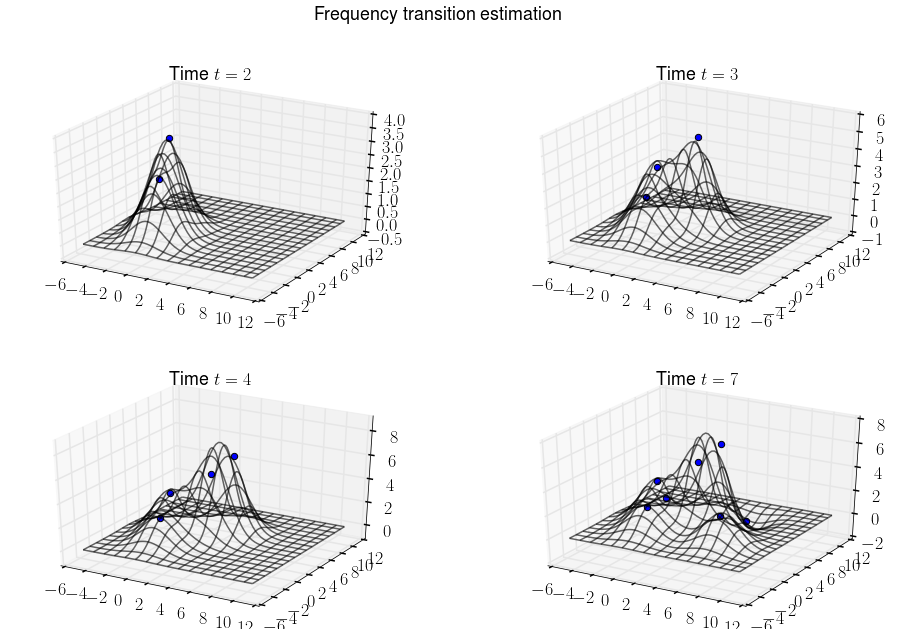

In [13]:
# Time-varying state transition function estimation
highlimit = max(xf[:7])
lowlimit  = min(xf[:7])
span      = highlimit - lowlimit
highlimit = 1.0 * np.ceil ( 1/1.0 * 0.5 * span + highlimit)
lowlimit  = 1.0 * np.floor(-1/1.0 * 0.5 * span + lowlimit)
gridx     = np.linspace(lowlimit, highlimit, 64)
gridy     = np.linspace(lowlimit, highlimit, 64)

# We'll observe the estimate at two moments: 30 and 90 seconds,
# which are the end points for both time-invariant zones.
# The estimates' first index correspond to the samples, of which
# the first 200 are discarded while the MCMC converges to the desired distribution
smean2 = np.mean(np.array(estimate[2 - 1][0][200:]), 0)
smean3 = np.mean(np.array(estimate[3 - 1][0][200:]), 0)
smean4 = np.mean(np.array(estimate[4 - 1][0][200:]), 0)
smean7 = np.mean(np.array(estimate[7 - 1][0][200:]), 0)

# The estimates' second index corresponds to the support vectors at that time
svectors2 = estimate[2 - 1][2]
svectors3 = estimate[3 - 1][2]
svectors4 = estimate[4 - 1][2]
svectors7 = estimate[7 - 1][2]

# The estimates' third index corresponds to the kernel descriptor
kernel2 = estimate[2 - 1][3]
kernel3 = estimate[3 - 1][3]
kernel4 = estimate[4 - 1][3]
kernel7 = estimate[7 - 1][3]

# Mean estimate and its marginal deviation
estmean2 = np.array([[kernel2.mixture_eval(smean2, svectors2, [i, k])[0] for k in gridy] for i in gridx])
estmean3 = np.array([[kernel3.mixture_eval(smean3, svectors3, [i, k])[0] for k in gridy] for i in gridx])
estmean4 = np.array([[kernel4.mixture_eval(smean4, svectors4, [i, k])[0] for k in gridy] for i in gridx])
estmean7 = np.array([[kernel7.mixture_eval(smean7, svectors7, [i, k])[0] for k in gridy] for i in gridx])

mgx, mgy = np.meshgrid(gridx, gridy)
sampledx = np.concatenate(([0], xf[:-2]))
sampledy = xf[:-1]
sampledz = xf[1:]

fig = mtp.figure(figsize = (16, 10))

ax = fig.add_subplot(2, 2, 1, projection="3d")
ax.plot_wireframe(mgx, mgy, estmean2, color=(0, 0, 0, 0.6), cstride=4, rstride=4, label="$\hat f_{2}$, KSSM estimate")
ax.scatter(sampledx[0:2], sampledy[0:2], sampledz[0:2], c="b", s=40,
           clip_on=False, depthshade=False, label="$s_{1:2}$, State samples")
ax.set_title("Time $t=2$")

ax = fig.add_subplot(2, 2, 2, projection="3d")
ax.plot_wireframe(mgx, mgy, estmean3, color=(0, 0, 0, 0.6), cstride=4, rstride=4, label="$\hat f_{3}$, KSSM estimate")
ax.scatter(sampledx[0:3], sampledy[0:3], sampledz[0:3], c="b", s=40,
           clip_on=False, depthshade=False, label="$s_{1:3}$, State samples")
ax.set_title("Time $t=3$")

ax = fig.add_subplot(2, 2, 3, projection="3d")
ax.plot_wireframe(mgx, mgy, estmean4, color=(0, 0, 0, 0.6), cstride=4, rstride=4, label="$\hat f_{4}$, KSSM estimate")
ax.scatter(sampledx[0:4], sampledy[0:4], sampledz[0:4], c="b", s=40,
           clip_on=False, depthshade=False, label="$s_{1:4}$, State samples")
ax.set_title("Time $t=4$")

ax = fig.add_subplot(2, 2, 4, projection="3d")
ax.plot_wireframe(mgx, mgy, estmean7, color=(0, 0, 0, 0.6), cstride=4, rstride=4, label="$\hat f_{7}$, KSSM estimate")
ax.scatter(sampledx[0:7], sampledy[0:7], sampledz[0:7], c="b", s=40,
           clip_on=False, depthshade=False, label="$s_{1:7}$, State samples")
ax.set_title("Time $t=7$")

fig.suptitle("Frequency transition estimation", fontsize=18)

mtp.show()